# Emotion Classification: Data Preparation

In this notebook, you'll:

- Upload up to 10 face images per emotion class.
- Organize them into folders by emotion.
- Split the dataset into training and testing sets.

**Emotions to capture:** `['happy', 'sad', 'angry', 'surprised', 'neutral']`

## 1. Setup and Imports
Install dependencies and import required modules:

In [1]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 7.5 MB/s eta 0:00:00


Loading and displaying one image from each sentiment folder...
Displayed image from angry folder: angry_5.jpg
Displayed image from happy folder: happy_1.jpg
Displayed image from neutral folder: neutral_4.jpg
Displayed image from sad folder: sad_0.jpg
Displayed image from surprised folder: surprised_6.jpg


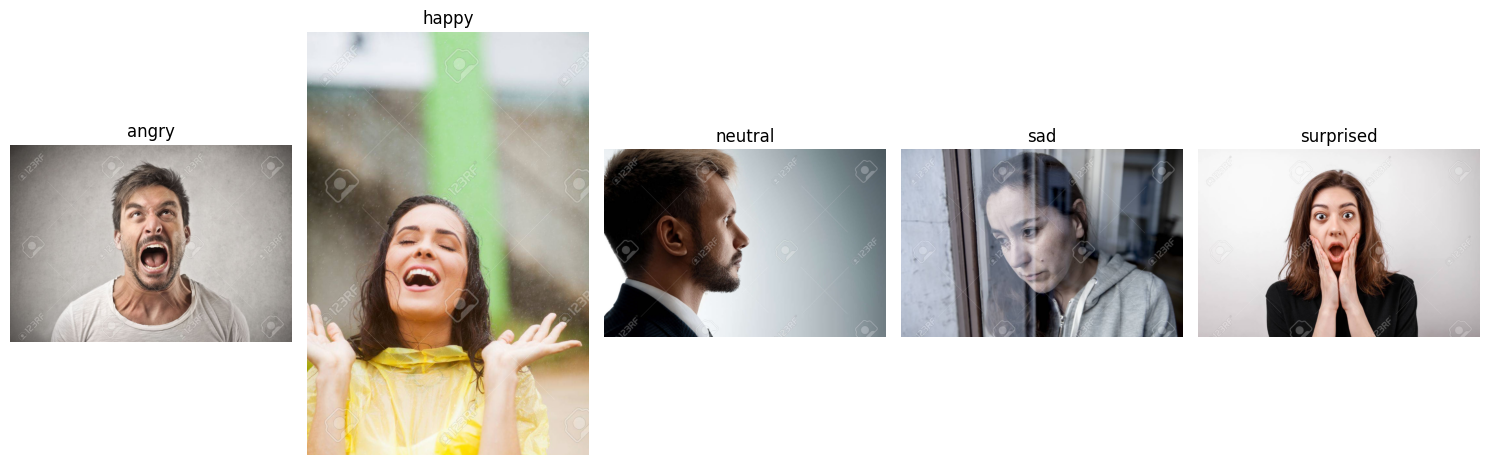

In [2]:
# Ensure you have necessary libraries installed
!pip install Pillow matplotlib opencv-python scikit-image numpy google-cloud-vision

# Import required libraries
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import exposure
from google.cloud import vision_v1 as vision
from google.cloud.vision_v1 import types
import io
import time

## Data Preparation & Visualization

print("Loading and displaying one image from each sentiment folder...")

# Define the base directory where your emotion folders are located
# Make sure this path is correct for your environment (e.g., Google Drive path)
data_dir = '/content/drive/MyDrive/stock_photos'


emotions = ['angry', 'happy', 'neutral', 'sad', 'surprised']

plt.figure(figsize=(15, 5))

for i, emo in enumerate(emotions):
    emotion_folder = os.path.join(data_dir, emo)
    if os.path.exists(emotion_folder):
        image_files = [f for f in os.listdir(emotion_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:
            # Select a random image from the folder
            img_name = random.choice(image_files)
            img_path = os.path.join(emotion_folder, img_name)

            try:
                # Load the image using Pillow
                img = Image.open(img_path)

                # Display the image
                plt.subplot(1, len(emotions), i + 1)
                plt.imshow(img)
                plt.title(emo)
                plt.axis('off')
                print(f"Displayed image from {emo} folder: {img_name}")

            except Exception as e:
                print(f"Could not load or display image {img_name} from {emo} folder: {e}")
        else:
            print(f"No image files found in {emo} folder.")
    else:
        print(f"Folder not found: {emotion_folder}")

plt.tight_layout()
plt.show()

## 2. Upload Images per Emotion
##For each emotion, upload up to 10 images. After selecting files, the dialog will close.

Images were added to google drive instead of being uploaded individually.


Applying image preprocessing (Grayscale, Resize, Normalize)...


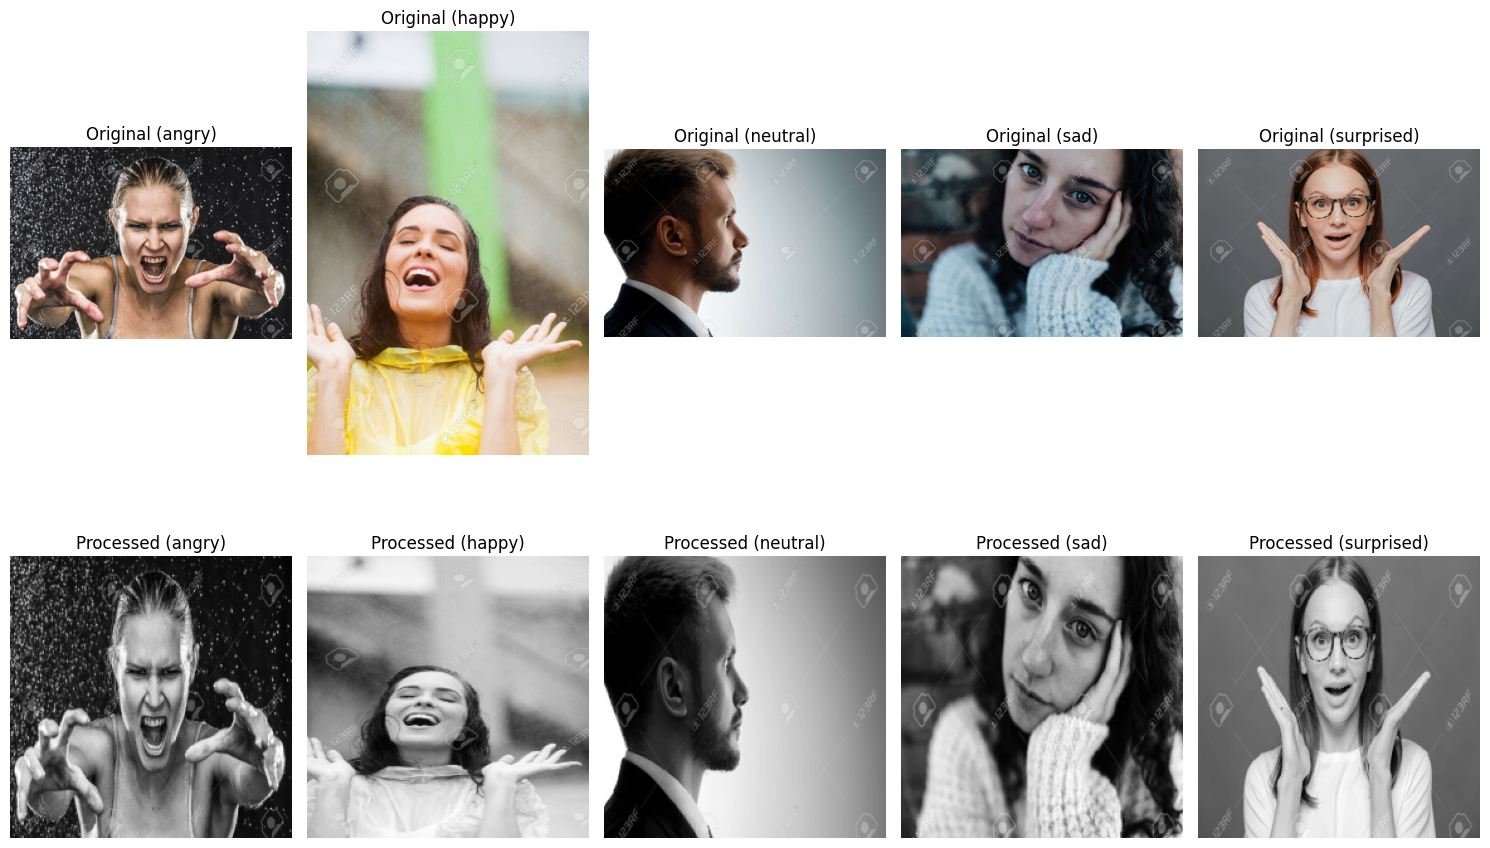

In [3]:
## Image Preprocessing

print("\nApplying image preprocessing (Grayscale, Resize, Normalize)...")

# Function to apply preprocessing
def preprocess_image(image_path):
    try:
        # Load image using OpenCV (better for preprocessing steps like color conversion)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error loading image: {image_path}")
            return None

        # 1. Grayscale conversion
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 2. Resize to 224x224
        resized_img = cv2.resize(gray_img, (224, 224), interpolation=cv2.INTER_AREA)

        # 3. Normalize pixel values (scale to [0, 1])
        normalized_img = resized_img.astype(np.float32) / 255.0

        return normalized_img

    except Exception as e:
        print(f"Error during preprocessing for {image_path}: {e}")
        return None

# Select one image from each emotion to demonstrate preprocessing
sample_images = {}
for emo in emotions:
     emotion_folder = os.path.join(data_dir, emo)
     if os.path.exists(emotion_folder):
         image_files = [f for f in os.listdir(emotion_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
         if image_files:
              sample_images[emo] = os.path.join(emotion_folder, random.choice(image_files))

processed_images = {}
plt.figure(figsize=(15, 10))

for i, emo in enumerate(emotions):
    if emo in sample_images:
        original_path = sample_images[emo]
        processed_img_array = preprocess_image(original_path)

        if processed_img_array is not None:
             processed_images[emo] = processed_img_array

             # Display the original image
             original_img = cv2.imread(original_path)
             original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
             plt.subplot(2, len(emotions), i + 1)
             plt.imshow(original_img_rgb)
             plt.title(f"Original ({emo})")
             plt.axis('off')

             # Display the processed image (grayscale, normalized)
             # Need to display grayscale arrays correctly
             plt.subplot(2, len(emotions), i + 1 + len(emotions))
             plt.imshow(processed_img_array, cmap='gray') # Use grayscale colormap
             plt.title(f"Processed ({emo})")
             plt.axis('off')
        else:
            print(f"Could not process image for {emo}.")

plt.tight_layout()
plt.show()

## 3. Prepare Train/Test Split
Gather all image paths and labels, then split:


Applying Classic CV Transforms (Gaussian Blur, Canny Edges, Histogram Equalization)...


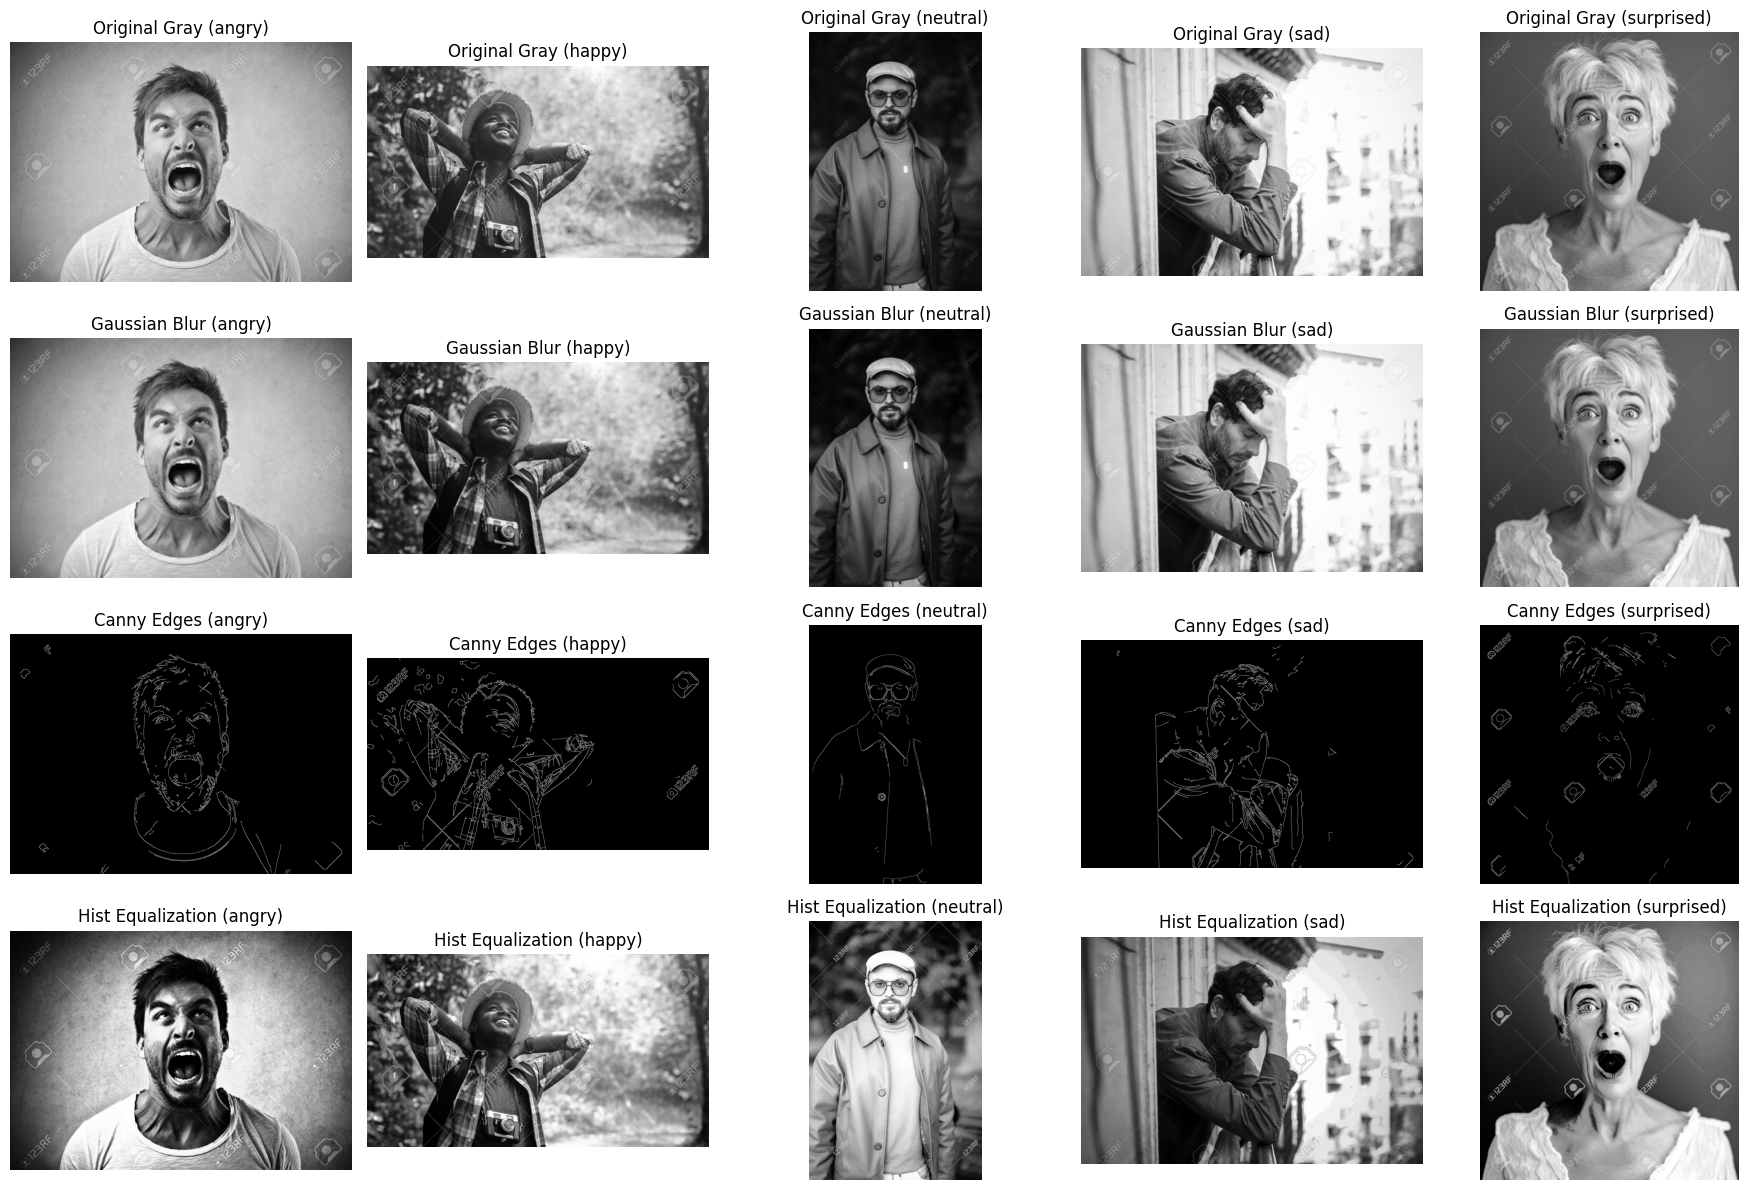

In [4]:
print("\nApplying Classic CV Transforms (Gaussian Blur, Canny Edges, Histogram Equalization)...")

plt.figure(figsize=(18, 12))

# Re-select one image from each emotion to demonstrate transforms
sample_images_transforms = {}
for emo in emotions:
     emotion_folder = os.path.join(data_dir, emo)
     if os.path.exists(emotion_folder):
         image_files = [f for f in os.listdir(emotion_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
         if image_files:
              sample_images_transforms[emo] = os.path.join(emotion_folder, random.choice(image_files))

transform_count = 3 # Gaussian, Canny, Hist Eq
subplot_rows = transform_count + 1 # Original + 3 transforms

for i, emo in enumerate(emotions):
    if emo in sample_images_transforms:
        original_path = sample_images_transforms[emo]

        try:
            # Load the image in grayscale for most transforms
            img_gray = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                 print(f"Error loading grayscale image for transforms: {original_path}")
                 continue

            # Display Original Grayscale
            plt.subplot(subplot_rows, len(emotions), i + 1)
            plt.imshow(img_gray, cmap='gray')
            plt.title(f"Original Gray ({emo})")
            plt.axis('off')

            # 1. Gaussian Blur
            blurred_img = cv2.GaussianBlur(img_gray, (5, 5), 0) # Kernel size 5x5, sigmaX = 0 (auto)
            plt.subplot(subplot_rows, len(emotions), i + 1 + len(emotions))
            plt.imshow(blurred_img, cmap='gray')
            plt.title(f"Gaussian Blur ({emo})")
            plt.axis('off')

            # 2. Canny Edge Detection
            # Apply slight blur before Canny for better results
            img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
            edges = cv2.Canny(img_blur, 100, 200) # Thresholds 100 and 200
            plt.subplot(subplot_rows, len(emotions), i + 1 + 2 * len(emotions))
            plt.imshow(edges, cmap='gray') # Edges are typically displayed grayscale
            plt.title(f"Canny Edges ({emo})")
            plt.axis('off')

            # 3. Histogram Equalization
            # Use skimage's equalize_hist for simplicity and effectiveness
            equalized_img = exposure.equalize_hist(img_gray)
            plt.subplot(subplot_rows, len(emotions), i + 1 + 3 * len(emotions))
            plt.imshow(equalized_img, cmap='gray') # Histogram equalized images are grayscale
            plt.title(f"Hist Equalization ({emo})")
            plt.axis('off')

        except Exception as e:
            print(f"Error applying transforms for {original_path}: {e}")

plt.tight_layout()
plt.show()

In [ ]:
print("\nApplying Feature Detection & Matching (ORB)...")

# Ensure you have opencv-contrib-python for SIFT/SURF if needed, but ORB is in main opencv
# If using SIFT/SURF, you might need: !pip install opencv-contrib-python

# Re-select two images from each emotion to demonstrate feature matching
sample_image_pairs = {}
for emo in emotions:
     emotion_folder = os.path.join(data_dir, emo)
     if os.path.exists(emotion_folder):
         image_files = [f for f in os.listdir(emotion_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
         if len(image_files) >= 2: # Need at least two images for a pair
              sample_image_pairs[emo] = random.sample(image_files, 2) # Select two unique images

plt.figure(figsize=(18, len(emotions) * 3)) # Adjust figure size based on number of emotions

# Initialize ORB detector
orb = cv2.ORB_create()

# Initialize feature matcher (using BFMatcher)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # NORM_HAMMING for ORB, crossCheck=True for better matches

for i, emo in enumerate(emotions):
    if emo in sample_image_pairs:
        img_name1, img_name2 = sample_image_pairs[emo]
        img_path1 = os.path.join(data_dir, emo, img_name1)
        img_path2 = os.path.join(data_dir, emo, img_name2)

        try:
            # Load images in grayscale
            img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)

            if img1 is None or img2 is None:
                 print(f"Error loading images for feature matching: {img_name1}, {img_name2} from {emo}")
                 continue

            # Find the keypoints and descriptors with ORB
            kp1, des1 = orb.detectAndCompute(img1, None)
            kp2, des2 = orb.detectAndCompute(img2, None)

            if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
                 print(f"Could not find descriptors for {img_name1} or {img_name2} in {emo}. Skipping.")
                 continue

            # Match descriptors
            matches = bf.match(des1, des2)

            # Sort them in the order of their distance (best matches first)
            matches = sorted(matches, key = lambda x:x.distance)

            # Draw top 20 matches
            num_matches_to_draw = min(20, len(matches))
            if num_matches_to_draw > 0:
                 img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:num_matches_to_draw], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

                 # Display the matches
                 plt.subplot(len(emotions), 1, i + 1)
                 plt.imshow(img_matches)
                 plt.title(f"Top {num_matches_to_draw} ORB Matches ({emo})")
                 plt.axis('off')
            else:
                 print(f"No sufficient matches found between {img_name1} and {img_name2} in {emo}.")


        except Exception as e:
            print(f"Error during feature matching for {img_name1}, {img_name2} from {emo}: {e}")
            # Optionally display the original images even if matching fails
            # display_original_pair(img_path1, img_path2, emo, i) # You would need to implement this helper

plt.tight_layout()
plt.show()

In [ ]:
## Cloud Inference

print("\nPerforming Cloud Inference (Google Cloud Vision)...")

# --- IMPORTANT ---
# You need to have authenticated with Google Cloud and set up your environment.
# If running in Colab, this usually involves:
# 1. Enabling the Vision API in your Google Cloud project.
# 2. Authenticating (e.g., using `google.colab.auth.authenticate_user()` or by setting GOOGLE_APPLICATION_CREDENTIALS).
# This code assumes authentication is already handled.
# -----------------

def cloud_predict(image_path):
    """Detects faces and extracts emotion likelihoods using Google Cloud Vision."""
    try:
        client = vision.ImageAnnotatorClient()

        with io.open(image_path, 'rb') as image_file:
            content = image_file.read()

        image = types.Image(content=content)

        # We request FACE_DETECTION feature
        # Note: The Vision API detects facial features and *attributes* including emotion likelihoods.
        response = client.face_detection(image=image)

        # Extract results
        face_annotations = response.face_annotations
        results = []

        if not face_annotations:
             results.append({"image": os.path.basename(image_path), "faces_detected": 0, "emotions": "No faces detected"})
        else:
            for face in face_annotations:
                 # Extract emotion likelihoods.
                 # Vision API provides JOY, SORROW, ANGER, SURPRISE likelihoods.
                 # NEUTRAL is inferred if none of these are likely.
                 emotions_detected = {
                      "joy": face.joy_likelihood,
                      "sorrow": face.sorrow_likelihood,
                      "anger": face.anger_likelihood,
                      "surprise": face.surprise_likelihood,
                      # Neutral is not directly a likelihood, infer from others
                      "neutral": "N/A (Inferred)"
                 }

                 # Convert likelihood enum to string (e.g., 'VERY_LIKELY', 'LIKELY')
                 likelihood_name = ('UNKNOWN', 'VERY_UNLIKELY', 'UNLIKELY', 'POSSIBLE', 'LIKELY', 'VERY_LIKELY')
                 emotion_likelihoods_str = {
                     emo: likelihood_name[like] for emo, like in emotions_detected.items() if isinstance(like, int) # Only convert int likelihoods
                 }
                 emotion_likelihoods_str["neutral"] = "N/A (Inferred if others are low)" # Re-add neutral explanation

                 results.append({
                      "image": os.path.basename(image_path),
                      "faces_detected": 1, # This dictionary represents one detected face
                      "emotions": emotion_likelihoods_str,
                      "detection_confidence": face.detection_confidence, # Confidence in face detection
                      "landmarking_confidence": face.landmarking_confidence # Confidence in face landmark detection
                 })

        # Check for errors in the response
        if response.error.message:
            print(f"API Error for {os.path.basename(image_path)}: {response.error.message}")
            # Append error to results or handle as needed
            results.append({"image": os.path.basename(image_path), "error": response.error.message})

        return results

    except Exception as e:
        print(f"An unexpected error occurred for {os.path.basename(image_path)}: {e}")
        return [{"image": os.path.basename(image_path), "error": str(e)}]

# Select 5 random images across sentiments for cloud inference
all_image_paths = []
for emo in emotions:
    emotion_folder = os.path.join(data_dir, emo)
    if os.path.exists(emotion_folder):
        image_files = [f for f in os.listdir(emotion_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_image_paths.extend([os.path.join(emotion_folder, f) for f in image_files])

# Ensure we have at least 5 images total
if len(all_image_paths) < 5:
    print(f"Warning: Only {len(all_image_paths)} images found across all folders. Need at least 5 for cloud inference demonstration.")
    images_for_cloud_inference = all_image_paths
else:
    images_for_cloud_inference = random.sample(all_image_paths, 5)

print(f"\nRunning Cloud Vision API on {len(images_for_cloud_inference)} images:")

cloud_results = []
for img_path in images_for_cloud_inference:
    start_time = time.time()
    result = cloud_predict(img_path)
    end_time = time.time()
    latency = (end_time - start_time) * 1000 # Latency in milliseconds
    print(f"Processed {os.path.basename(img_path)} in {latency:.2f} ms")

    # Add latency to results
    if result:
        # If multiple faces detected, add latency to each result dict
        for res in result:
            res["latency_ms"] = latency
            cloud_results.append(res)
    else:
         cloud_results.append({"image": os.path.basename(img_path), "error": "No result from cloud_predict function", "latency_ms": latency})


# Display the results
print("\nCloud Vision API Results:")
for res in cloud_results:
    print(f"- Image: {res.get('image', 'N/A')}")
    if res.get('error'):
        print(f"  Error: {res['error']}")
    elif res.get('faces_detected') == 0:
         print("  No faces detected.")
         print(f"  Latency: {res.get('latency_ms', 'N/A'):.2f} ms")
    else:
        print(f"  Faces Detected: {res.get('faces_detected', 'N/A')}")
        # If the result contains multiple face dictionaries, iterate
        if isinstance(res.get('emotions'), dict): # Check if 'emotions' is a single face dict
             print(f"  Emotions: {res['emotions']}")
             print(f"  Detection Confidence: {res.get('detection_confidence', 'N/A'):.2f}")
             print(f"  Landmarking Confidence: {res.get('landmarking_confidence', 'N/A'):.2f}")
             print(f"  Latency: {res.get('latency_ms', 'N/A'):.2f} ms")
        else: # Handle case where cloud_predict might return multiple face results in one entry (though current code returns list of dicts)
             print(f"  Emotion Details: {res.get('emotions', 'N/A')}")
             print(f"  Latency: {res.get('latency_ms', 'N/A'):.2f} ms")
    print("-" * 20) # Separator

## 4. Save Split Lists
Export file lists and labels to CSV for future use:

In [ ]:
# --- This code is illustrative and NOT in your provided notebook ---
import pandas as pd
from sklearn.model_selection import train_test_split

# (Assuming data_dir and emotions are already defined and exist)

all_image_paths = []
all_image_labels = []

# Gather all image paths and labels
for emo in emotions:
    emotion_folder = os.path.join(data_dir, emo)
    if os.path.exists(emotion_folder):
        image_files = [f for f in os.listdir(emotion_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Create full paths and assign labels
        image_paths_in_folder = [os.path.join(emotion_folder, f) for f in image_files]
        labels_in_folder = [emo] * len(image_files) # Repeat the emotion label for each image

        all_image_paths.extend(image_paths_in_folder)
        all_image_labels.extend(labels_in_folder)

print(f"Total images found: {len(all_image_paths)}")

# Perform the train-test split (e.g., 80% train, 20% test)
# stratify=all_image_labels ensures the split is proportional to the label distribution
# random_state ensures the split is the same each time you run it
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_image_labels, test_size=0.2, random_state=42, stratify=all_image_labels
)

print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")

# Create DataFrames to easily save to CSV
train_df = pd.DataFrame({'image_path': train_paths, 'label': train_labels})
test_df = pd.DataFrame({'image_path': test_paths, 'label': test_labels})

# Define filenames for saving (e.g., in the same data_dir or a dedicated split folder)
train_csv_path = os.path.join(data_dir, 'train_split.csv')
test_csv_path = os.path.join(data_dir, 'test_split.csv')

# Save the DataFrames to CSV files
train_df.to_csv(train_csv_path, index=False) # index=False prevents writing the DataFrame index as a column
test_df.to_csv(test_csv_path, index=False)

print(f"\nTraining list saved to: {train_csv_path}")
print(f"Testing list saved to: {test_csv_path}")
# --- End of illustrative code ---

Aswer reflection in markdown

1. **Hidden Bias:**  
   Identify one scenario where your current images might lead the model to learn a spurious signal (e.g. background, lighting). How would you test for and eliminate it?

2. **Edge Cases:**  
   Describe a face or expression that your dataset likely fails to capture. What impact could that have on real-world performance, and how would you address it?

3. **Generalization Strategy:**  
   With only 10 images per class, what’s one concrete augmentation or data-collection strategy you’d use to improve robustness—and why that choice?






